In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>")) #Set scaling for the jupyter notebook cell width - make them bigger

In [2]:
#General packages
from IPython.display import clear_output #import of a single funtcion
import sys #system related packages
import os #better path and file handling
import pickle #saving and loading objects

#Tables, numbers etc
import pandas as pd #tables
import numpy as np #arrays
import scipy #sciency functions
from sklearn import mixture #For gaussian mixture model

#Plotting packages
import matplotlib.pyplot as plt #Main plotting
from matplotlib.ticker import MaxNLocator
from matplotlib.lines import Line2D
import seaborn as sbn #nicer plots

#RNA-seq analysis
import scanpy as sc #Main package for scRNA-seq analysis
import scanpy.external as sce #some more functions for scanpy
import bbknn #batch correction
import anndata #anndata objects
import gseapy #GSE analysis

from adjustText import adjust_text
from matplotlib.ticker import MaxNLocator

root = '/mnt/c' if 'mnt' in os.getcwd() else 'C:' #root path depending on which environment I use

#Import some custom helper functions for plotting
sys.path.append('/mnt/c/Users/User/Karl/Python')
from Skin_scripts import *

In [3]:
#Print package versions for important packages (matplotlib and seaborn are excluded from this list)
sc.logging.print_header()

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.23.3 scipy==1.9.3 pandas==1.4.4 scikit-learn==1.1.3 statsmodels==0.13.2 python-igraph==0.9.1 pynndescent==0.5.4


# Method for DGE analysis

In [4]:
method = 'wilcoxon'

In [5]:
def annotate_deg_df(deg_df, dge_data, deg_lfc_cutoff = [0.5, 1], p_value = 0.05, inf_p = 300, pct_cutoff = 25):
    deg_df['-log10(pvals_adj)'] = -np.log10(deg_df['pvals_adj'])
    
        
    deg_df['-log10(pvals_adj)'] = [inf_p if x==np.inf else x for x in deg_df['-log10(pvals_adj)']]
    
    counts = pd.DataFrame(data = dge_data.raw.X.toarray(), index = dge_data.obs['orig.ident'], columns = dge_data.raw.var_names)
    
    tmp = counts.copy()
    tmp.index = tmp.index.map(lambda x: ''.join([i for i in x if not i.isdigit()]))
    tmp = (tmp>0).reset_index().groupby('orig.ident').sum().div((tmp>=0).reset_index().groupby('orig.ident').sum())*100
    deg_df[[f'pct. {s}' for s in tmp.index]] = tmp[deg_df['names']].T.reset_index(drop = True)
    pct_columns = [f'pct. {s}' for s in tmp.index]
    
    counts = counts.reset_index(drop = False).groupby(['orig.ident']).sum()>0
    counts.index = counts.index.map(lambda x: ''.join([i for i in x if not i.isdigit()]))
    counts = counts.reset_index(drop = False).groupby(['orig.ident']).sum()

    
    deg_df['Samples'] = np.where(counts[deg_df['names']].sum()==6, 'All samples', 'Some samples')
    deg_df[[f'Expr. samples {s}' for s in counts.index]] = counts[deg_df['names']].T.reset_index(drop = True)
    
    for i in deg_lfc_cutoff:
        deg_df[f'DEG lfc:{i}'] = np.where(
            (deg_df['-log10(pvals_adj)']>-np.log10(p_value)) & (abs(deg_df['logfoldchanges'])>i) & (deg_df['Samples']=='All samples') & (deg_df[pct_columns[0]]>pct_cutoff) & (deg_df[pct_columns[1]]>pct_cutoff), 
            'DEG', 'Non-DEG')
        
    return deg_df

In [6]:
date = 23112022

# Read in datasets

In [7]:
path = '/mnt/e/IMPORTANT-Backup-Sequencing-Projects/2021-Greco-Sara-Nur-Help/Rebuttal_2022_Analysis'
adata = sc.read_h5ad(os.path.join(path, 'IFE_Combined_datasets_Annotated.h5ad'))

In [8]:
path = '/mnt/e/IMPORTANT-Backup-Sequencing-Projects/2021-Greco-Sara-Nur-Help/Rebuttal_2022_Analysis'
adata.raw = sc.read_loom(os.path.join(path, 'IFE_Combined_datasets.loom'), validate = False)[adata.obs_names]

# Combine datasets for DGE analysis

In [70]:
#Make sure that cells are in the same order
comb_data = adata[adata.obs_names.intersection(raw_data.obs_names)].copy()
comb_data.obs['dataset'] = adata.obs['batch'].copy()
#This gets lost in the loom file and leads to errors below
comb_data.uns['log1p']['base']=None
comb_data.obs['Wound'] = adata.obs['Wound_comb'].copy()

In [71]:
comb_data = comb_data[cells].copy()
comb_data

AnnData object with n_obs × n_vars = 54311 × 14716
    obs: 'Commitment', 'G2M_score', 'GFP_class', 'Immune', 'Immune21', 'Infu', 'Infundibulum1', 'Krt6_class', 'Krt6a_class', 'Krt6b_class', 'Location', 'RBC1', 'RNA_snn_res.0.1', 'Replicate', 'S_score', 'Stress', 'Tomato_class', 'Wound', 'batch', 'binned_delamination', 'dpt_ordered', 'dpt_pseudotime', 'dpt_reordered', 'geno', 'imm_score', 'induction', 'infu_score', 'injury', 'integrated_snn_res.0.1', 'leiden', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'log1p_total_counts_hemo', 'log1p_total_counts_mito', 'log1p_total_counts_ribo', 'nCount_RNA', 'nFeature_RNA', 'n_genes_by_counts', 'orig.ident', 'pct_counts_hemo', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'pct_counts_in_top_50_genes', 'pct_counts_mito', 'pct_counts_ribo', 'percent.mt', 'phase', 'seurat_clusters', 'stress_score', 'tdt_info', 'total_counts', 'total_counts_hemo', 'total_counts_mito', 'total_counts_ribo', 'umap_densi

### Make tomato annotation the same

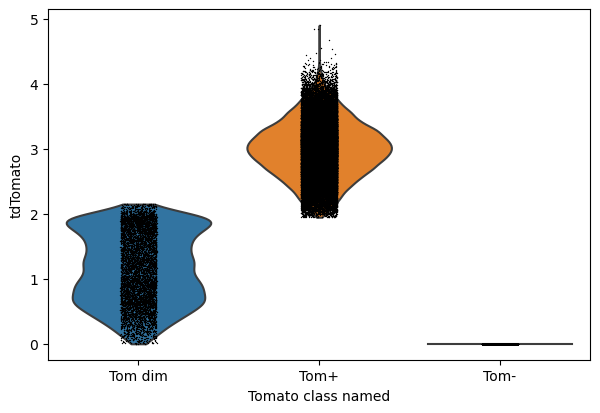

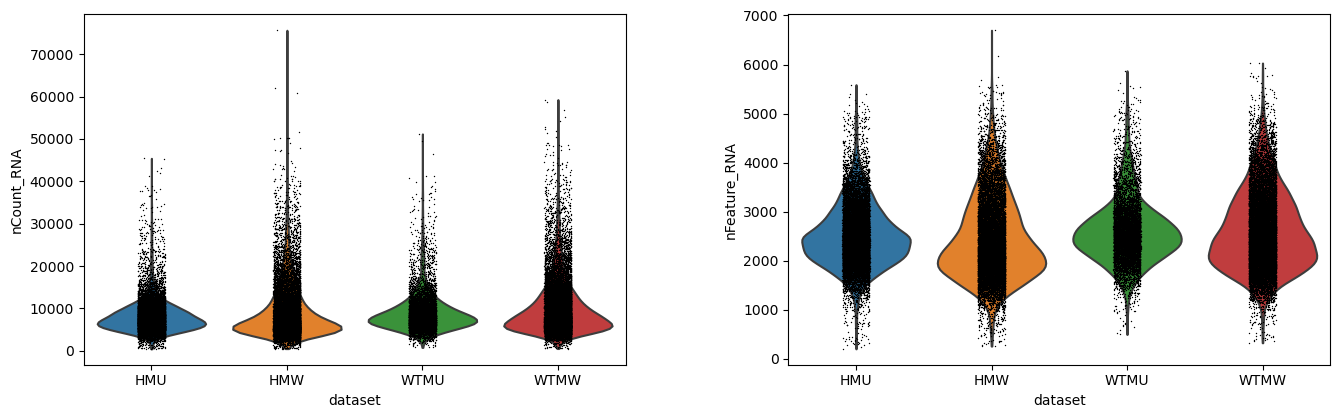

In [73]:
tomato_map = {0:'Tom+', 1: 'Tom dim', 2: 'Tom-'}
comb_data.obs['Tomato_class_named'] = comb_data.obs['Tomato_class'].apply(lambda x: tomato_map[x] if type(x)==int else x)
sc.pl.violin(comb_data, keys = ['tdTomato'], groupby = 'Tomato_class_named')
sc.pl.violin(comb_data, keys = ['nCount_RNA', 'nFeature_RNA'], groupby = 'dataset')
clear_output(wait = True)

# Subset datasets to specific cells

## This: BC+BNC, GFP+, Tom+

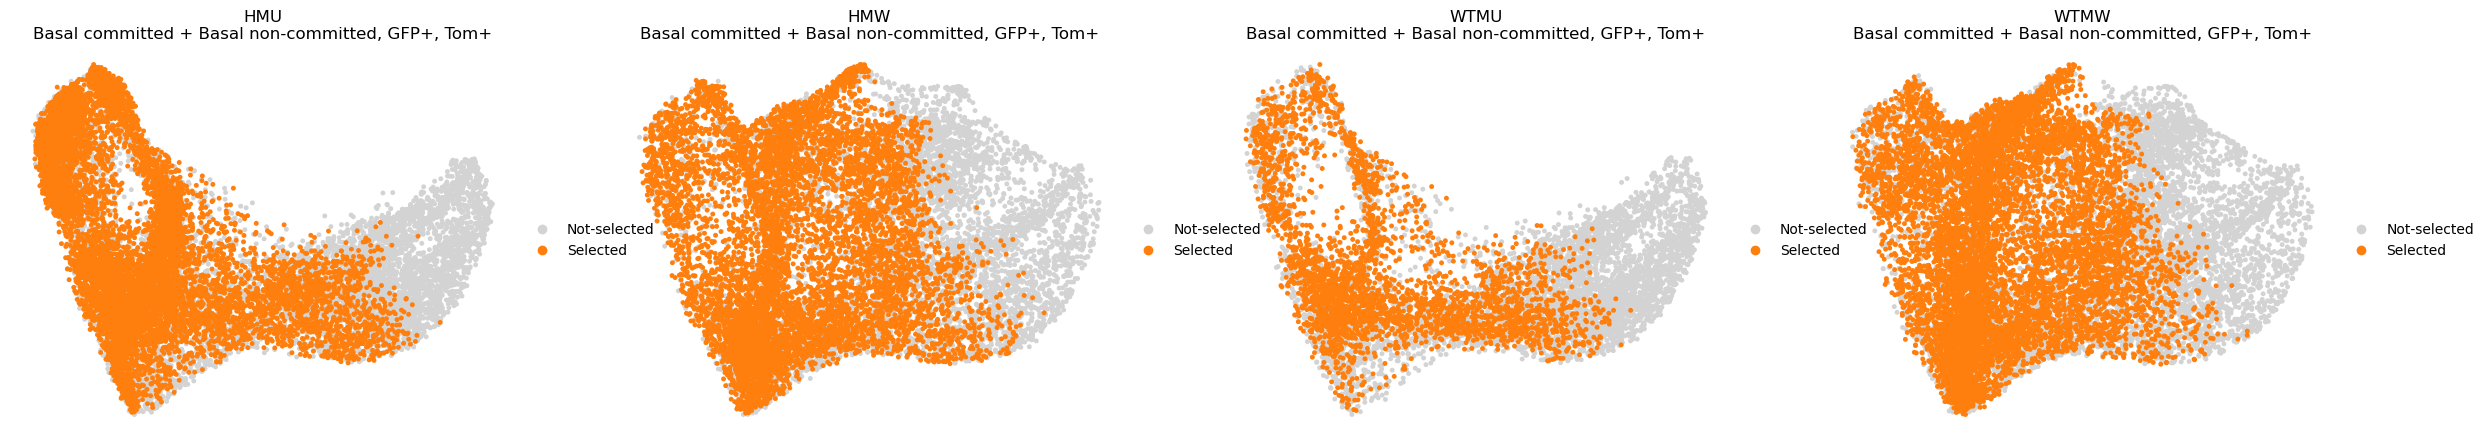

In [74]:
Tomato_class = 'Tom+'
GFP_class = 'GFP+'
commitment = ['Basal committed', 'Basal non-committed']
selection_title = f'{" + ".join(commitment) if type(commitment)==list else commitment}, {GFP_class}, {Tomato_class}'

selection = (comb_data.obs['Commitment'].isin(commitment)) & (comb_data.obs['GFP_class'] == GFP_class) & (comb_data.obs['Tomato_class_named']==Tomato_class)
comb_data.obs['DGE selected cells'] = np.where(selection, 'Selected', 'Not-selected')

cmap = {'Not-selected': 'lightgray', 'Selected':sbn.color_palette(n_colors = 2, palette = 'tab10')[1]}
ncols = len(comb_data.obs['dataset'].unique())
fig, axes = plt.subplots(ncols = ncols, figsize = (7.5*ncols, 5))
for ix, dataset in enumerate(comb_data.obs['dataset'].unique()):
    ax = axes[ix]
    for sel in ['Not-selected', 'Selected']:
        sc.pl.umap(comb_data[(comb_data.obs['dataset']==dataset) & (comb_data.obs['DGE selected cells']==sel)], color = 'DGE selected cells', ax = ax, show = False, frameon = False, palette = cmap, s = 50)
    ax.set_title(f'{dataset}\n{selection_title}')
clear_output(wait = True)

### This: HMU vs WTMU

In [75]:
datasets = ['HMU','WTMU']
dge_data = comb_data[selection & (comb_data.obs['dataset'].isin(datasets))].copy()
dge_data

AnnData object with n_obs × n_vars = 11973 × 14716
    obs: 'Commitment', 'G2M_score', 'GFP_class', 'Immune', 'Immune21', 'Infu', 'Infundibulum1', 'Krt6_class', 'Krt6a_class', 'Krt6b_class', 'Location', 'RBC1', 'RNA_snn_res.0.1', 'Replicate', 'S_score', 'Stress', 'Tomato_class', 'Wound', 'batch', 'binned_delamination', 'dpt_ordered', 'dpt_pseudotime', 'dpt_reordered', 'geno', 'imm_score', 'induction', 'infu_score', 'injury', 'integrated_snn_res.0.1', 'leiden', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'log1p_total_counts_hemo', 'log1p_total_counts_mito', 'log1p_total_counts_ribo', 'nCount_RNA', 'nFeature_RNA', 'n_genes_by_counts', 'orig.ident', 'pct_counts_hemo', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'pct_counts_in_top_50_genes', 'pct_counts_mito', 'pct_counts_ribo', 'percent.mt', 'phase', 'seurat_clusters', 'stress_score', 'tdt_info', 'total_counts', 'total_counts_hemo', 'total_counts_mito', 'total_counts_ribo', 'umap_densi

#### Find DEGs

... storing 'DGE selected cells' as categorical


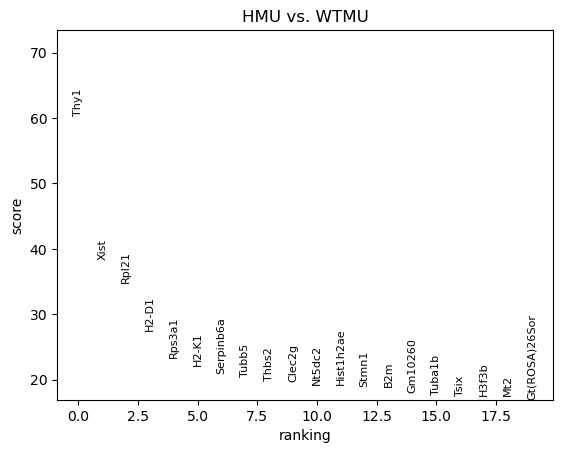

In [76]:
sc.tl.rank_genes_groups(dge_data, groupby = 'dataset', method=method, groups = [datasets[0]], reference = datasets[1], pts = True)
sc.pl.rank_genes_groups(dge_data)

#### DEG table and save

NOTE! If adjusted p-value is 0, then replace -log10(pvals_adj) with 300 or 400 to avoid infinities being in the data

In [77]:
deg_df = sc.get.rank_genes_groups_df(dge_data, group = datasets[0])
deg_df = annotate_deg_df(deg_df, dge_data, deg_lfc_cutoff = [0.5, 1], p_value = 0.05)

deg_df.to_csv(os.path.join(path, f'{datasets[0]}_vs_{datasets[1]}_IFE_BNC_BC_{GFP_class}_{Tomato_class}_DEG_{date}.csv'))
deg_df

/home/user/anaconda3/envs/karlpy/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,names,scores,logfoldchanges,pvals,pvals_adj,pct_nz_group,-log10(pvals_adj),pct. HMU,pct. WTMU,Samples,Expr. samples HMU,Expr. samples WTMU,DEG lfc:0.5,DEG lfc:1
0,Thy1,60.387989,10.453644,0.000000e+00,0.000000e+00,0.312693,300.000000,31.269350,0.092251,Some samples,3,1,Non-DEG,Non-DEG
1,Xist,38.291759,1.894942,2.270941e-290,1.005062e-286,0.660933,285.997807,66.093338,32.933579,Some samples,2,2,Non-DEG,Non-DEG
2,Rpl21,34.854012,0.388491,8.116846e-245,2.873850e-241,0.999771,240.541536,99.977067,99.907749,All samples,3,3,Non-DEG,Non-DEG
3,H2-D1,27.479685,0.764082,4.836441e-157,8.561951e-154,0.950235,153.067427,95.023506,91.205412,All samples,3,3,DEG,Non-DEG
4,Rps3a1,23.346853,0.246763,3.124125e-116,4.254337e-113,0.999427,112.371168,99.942667,100.000000,All samples,3,3,Non-DEG,Non-DEG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17698,Rps2,-32.951714,-0.326362,1.933017e-221,4.277524e-218,0.999656,217.368808,99.965600,100.000000,All samples,3,3,Non-DEG,Non-DEG
17699,tdTomato,-33.554562,-0.430463,1.382580e-223,3.496544e-220,1.000000,219.456361,100.000000,100.000000,All samples,3,3,Non-DEG,Non-DEG
17700,Ubb,-34.275711,-0.652578,6.248128e-238,1.843510e-234,0.970416,233.734354,97.041624,99.384994,All samples,3,3,DEG,Non-DEG
17701,Rps18,-40.905106,-0.467778,0.000000e+00,0.000000e+00,0.998853,300.000000,99.885334,100.000000,All samples,3,3,Non-DEG,Non-DEG


#### Volcano plot

Annotate and plot only top20 genes (by scores = z-scores used to calculate the p-value)

500

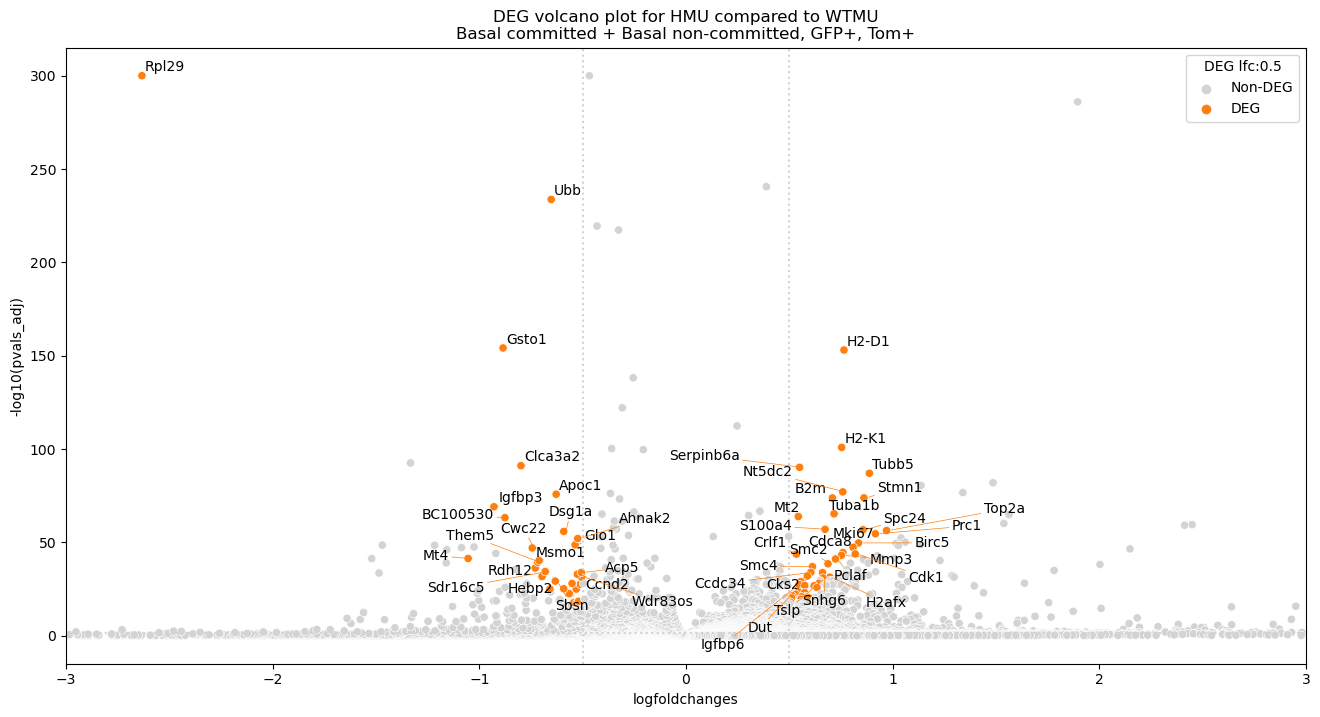

In [81]:
fig, ax = plt.subplots(figsize = (16, 8))
cmap = {'Non-DEG': 'lightgray', 'DEG':sbn.color_palette(n_colors = 2, palette = 'tab10')[1]}
sbn.scatterplot(data = deg_df, x = 'logfoldchanges', y = '-log10(pvals_adj)', hue = 'DEG lfc:0.5', ax = ax, palette = cmap)
ax.axhline(-np.log10(0.05), ls = ':', c = 'lightgrey')
[ax.axvline(y, ls = ':', c = 'lightgrey') for y in [-0.5, 0.5]]
ax.set_xlim([-3, 3])
ax.set_title(f'DEG volcano plot for {datasets[0]} compared to {datasets[1]}\n{selection_title}')
if deg_df['DEG lfc:0.5'].value_counts()['DEG'] < 50:
    texts = [ax.text(x+0.01, y+0.01, s) for x, y, s in deg_df[deg_df['DEG lfc:0.5']=='DEG'][['logfoldchanges', '-log10(pvals_adj)', 'names']].values]
else:
    idxs = abs(deg_df[deg_df['DEG lfc:0.5']=='DEG']['scores']).sort_values(ascending = False).index[:50]
    texts = [ax.text(x+0.01, y+0.01, s) for x, y, s in deg_df[deg_df['DEG lfc:0.5']=='DEG'].loc[idxs][['logfoldchanges', '-log10(pvals_adj)', 'names']].values]
adjust_text(texts, arrowprops=dict(arrowstyle="-", color=cmap['DEG'], lw=0.5))

#### DEG violinplot by dataset

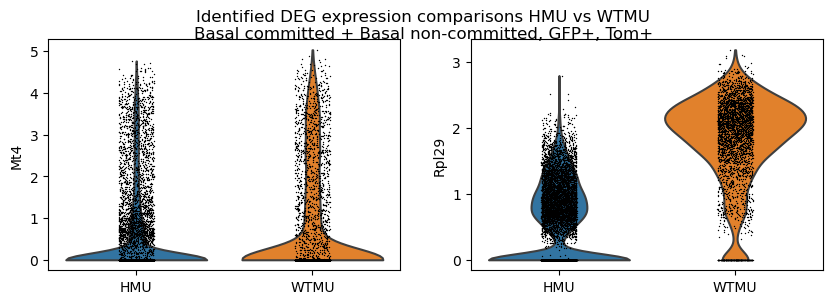

In [79]:
genes = deg_df[deg_df['DEG lfc:1']=='DEG']['names']
if len(genes) > 20:
    idxs = abs(deg_df[deg_df['DEG lfc:1']=='DEG']['scores']).sort_values(ascending = False).index[:20]
    genes = deg_df.loc[idxs, 'names']
    
ncols = 5 if len(genes) > 5 else len(genes)
nrows = int(np.ceil(len(genes)/ncols))
fig, axes = plt.subplots(ncols = ncols, nrows = nrows, figsize = (5*ncols,3*nrows))
for ix, g in enumerate(sorted(genes)):
    ax = get_ax(axes, ix, ncols)
    sc.pl.violin(dge_data, keys = g, groupby = 'dataset', ax = ax, show = False, frameon=False, palette = 'tab10')
    ax.set_xlabel('')
    ax.yaxis.set_major_locator(MaxNLocator(integer = True))

fig.suptitle(f'Identified DEG expression comparisons {datasets[0]} vs {datasets[1]}\n{selection_title}')
clean_subplots(ix, axes, ncols)

### This: HMW (wound) vs WTMW (wound)

In [33]:
datasets = ['HMW','WTMW']
wound = 'Wound'
dge_data = comb_data[selection & (comb_data.obs['dataset'].isin(datasets)) & (comb_data.obs['Wound']==wound)].copy()
dge_data

AnnData object with n_obs × n_vars = 4996 × 14716
    obs: 'Commitment', 'G2M_score', 'GFP_class', 'Immune', 'Immune21', 'Infu', 'Infundibulum1', 'Krt6_class', 'Krt6a_class', 'Krt6b_class', 'Location', 'RBC1', 'RNA_snn_res.0.1', 'Replicate', 'S_score', 'Stress', 'Tomato_class', 'Wound', 'batch', 'binned_delamination', 'dpt_ordered', 'dpt_pseudotime', 'dpt_reordered', 'geno', 'imm_score', 'induction', 'infu_score', 'injury', 'integrated_snn_res.0.1', 'leiden', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'log1p_total_counts_hemo', 'log1p_total_counts_mito', 'log1p_total_counts_ribo', 'nCount_RNA', 'nFeature_RNA', 'n_genes_by_counts', 'orig.ident', 'pct_counts_hemo', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'pct_counts_in_top_50_genes', 'pct_counts_mito', 'pct_counts_ribo', 'percent.mt', 'phase', 'seurat_clusters', 'stress_score', 'tdt_info', 'total_counts', 'total_counts_hemo', 'total_counts_mito', 'total_counts_ribo', 'umap_densit

#### Find DEGs

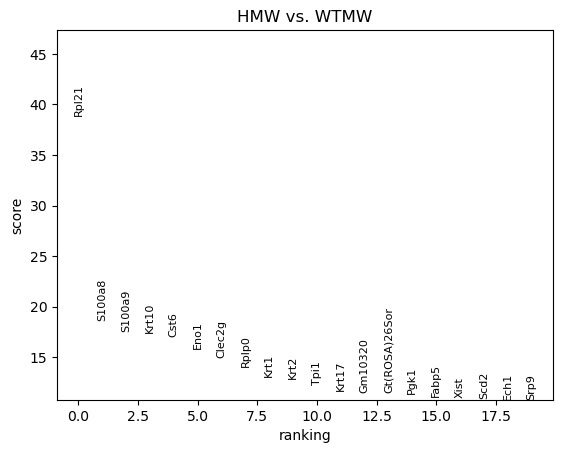

In [34]:
sc.tl.rank_genes_groups(dge_data, groupby = 'dataset', method=method, groups = [datasets[0]], reference = datasets[1], pts = True)
sc.pl.rank_genes_groups(dge_data)

#### DEG table and save

In [35]:
deg_df = sc.get.rank_genes_groups_df(dge_data, group = datasets[0])
deg_df = annotate_deg_df(deg_df, dge_data, deg_lfc_cutoff = [0.5, 1], p_value = 0.05)

deg_df.to_csv(os.path.join(path, f'{datasets[0]}({wound})_vs_{datasets[1]}({wound})_IFE_BNC_BC_{GFP_class}_{Tomato_class}_DEG_{date}.csv'))
deg_df

/home/user/anaconda3/envs/karlpy/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,names,scores,logfoldchanges,pvals,pvals_adj,pct_nz_group,-log10(pvals_adj),pct. HMW,pct. WTMWW,Samples,Expr. samples HMW,Expr. samples WTMWW,DEG lfc:0.5,DEG lfc:1
0,Rpl21,38.918285,0.545120,0.000000e+00,0.000000e+00,0.998254,300.000000,99.825404,99.889094,All samples,3,3,DEG,Non-DEG
1,S100a8,18.574844,1.280475,5.135434e-77,1.136407e-73,0.824094,72.944466,82.409428,61.035120,All samples,3,3,DEG,DEG
2,S100a9,17.485996,1.170838,1.831828e-68,3.242885e-65,0.856831,64.489069,85.683108,65.101664,All samples,3,3,DEG,DEG
3,Krt10,17.425188,1.272902,5.313270e-68,8.550984e-65,0.805762,64.067984,80.576168,46.691312,All samples,3,3,DEG,DEG
4,Cst6,17.058443,1.127934,3.025069e-65,4.119446e-62,0.563946,61.385161,56.394588,27.134935,All samples,3,3,DEG,DEG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17698,Tmem14c,-20.384720,-0.665630,2.285180e-92,6.742423e-89,0.838062,88.171184,83.806198,92.975970,All samples,3,3,DEG,Non-DEG
17699,Sec61b,-21.811464,-0.811455,1.806030e-105,6.394431e-102,0.756438,101.194198,75.643824,90.905730,All samples,3,3,DEG,Non-DEG
17700,tdTomato,-26.170465,-0.463733,5.765168e-151,2.551519e-147,1.000000,146.593201,100.000000,100.000000,All samples,3,3,Non-DEG,Non-DEG
17701,Ubb,-29.057802,-0.619666,1.226371e-185,7.236817e-182,0.986032,181.140452,98.603230,99.741220,All samples,3,3,DEG,Non-DEG


#### Volcano plot

Annotate and plot only top20 genes (by scores = z-scores used to calculate the p-value)

48

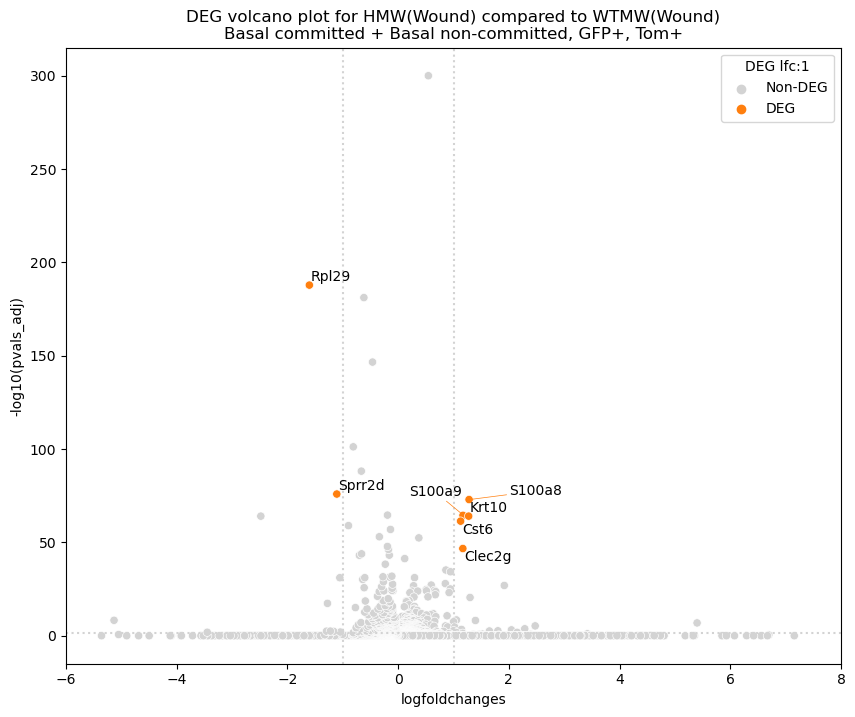

In [36]:
fig, ax = plt.subplots(figsize = (10, 8))
cmap = {'Non-DEG': 'lightgray', 'DEG':sbn.color_palette(n_colors = 2, palette = 'tab10')[1]}
sbn.scatterplot(data = deg_df, x = 'logfoldchanges', y = '-log10(pvals_adj)', hue = 'DEG lfc:1', ax = ax, palette = cmap)
ax.axhline(-np.log10(0.05), ls = ':', c = 'lightgrey')
[ax.axvline(y, ls = ':', c = 'lightgrey') for y in [-1, 1]]
ax.set_xlim([-6, 8])
ax.set_title(f'DEG volcano plot for {datasets[0]}({wound}) compared to {datasets[1]}({wound})\n{selection_title}')
if deg_df['DEG lfc:1'].value_counts()['DEG'] < 20:
    texts = [ax.text(x+0.01, y+0.01, s) for x, y, s in deg_df[deg_df['DEG lfc:1']=='DEG'][['logfoldchanges', '-log10(pvals_adj)', 'names']].values]
else:
    idxs = abs(deg_df[deg_df['DEG lfc:1']=='DEG']['scores']).sort_values(ascending = False).index[:20]
    texts = [ax.text(x+0.01, y+0.01, s) for x, y, s in deg_df[deg_df['DEG lfc:1']=='DEG'].loc[idxs][['logfoldchanges', '-log10(pvals_adj)', 'names']].values]
adjust_text(texts, arrowprops=dict(arrowstyle="-", color=cmap['DEG'], lw=0.5))

#### DEG violinplot by dataset

[<AxesSubplot:>]
[<AxesSubplot:>]
[<AxesSubplot:>]


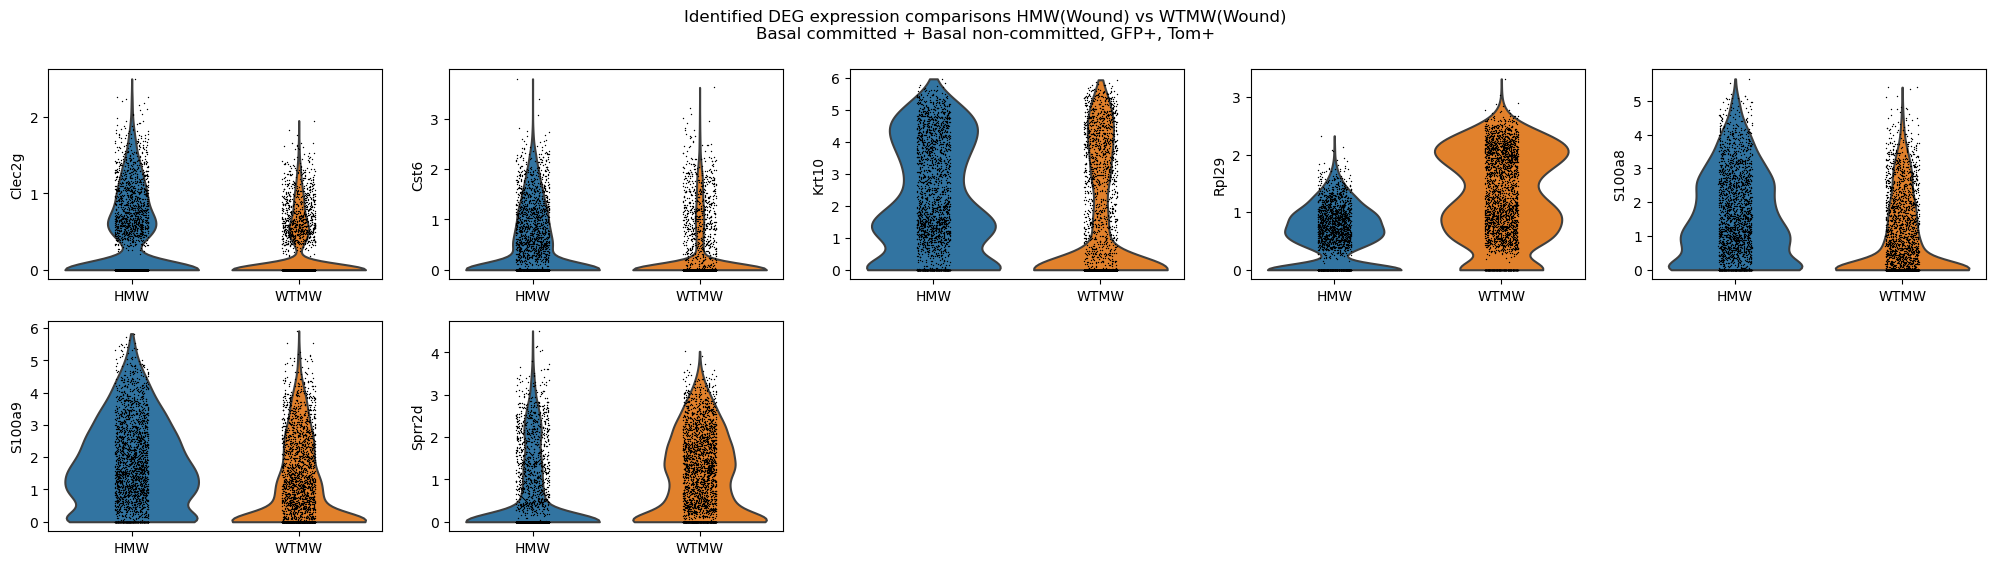

In [37]:
genes = deg_df[deg_df['DEG lfc:1']=='DEG']['names']
if len(genes) > 20:
    idxs = abs(deg_df[deg_df['DEG lfc:1']=='DEG']['scores']).sort_values(ascending = False).index[:20]
    genes = deg_df.loc[idxs, 'names']
    
ncols = 5 if len(genes) > 5 else len(genes)
nrows = int(np.ceil(len(genes)/ncols))
fig, axes = plt.subplots(ncols = ncols, nrows = nrows, figsize = (5*ncols,3*nrows))
for ix, g in enumerate(sorted(genes)):
    ax = get_ax(axes, ix, ncols)
    sc.pl.violin(dge_data, keys = g, groupby = 'dataset', ax = ax, show = False, frameon=False, palette = 'tab10')
    ax.set_xlabel('')
    ax.yaxis.set_major_locator(MaxNLocator(integer = True))

fig.suptitle(f'Identified DEG expression comparisons {datasets[0]}({wound}) vs {datasets[1]}({wound})\n{selection_title}')
clean_subplots(ix, axes, ncols)

# GSE analysis

In [43]:
path = '/mnt/c/Users/User/Desktop/To Be Deleted/Delete me!/Sara_seq_raw_loom'

In [44]:
path = os.path.join(path, 'GSEA_23112022')

In [45]:
gene_set_names = gseapy.get_library_name(organism = 'Mouse')
[x for x in gene_set_names if 'skin' in x.lower()]

[]

## GO_Biological_Process

Include genes where:

pvals_adj > 0.05

abs(logfoldchange)>0.5

Expressed in all samples

In [47]:
gene_sets = ['GO_Biological_Process_2021', 'GO_Biological_Process_2018']

res_dict = {}
for f in os.listdir(path):
    if '.csv' in f:
        res_dict[f] = {}
        dge_df = pd.read_csv(os.path.join(path, f), index_col = 0)
        
        genes_up = dge_df[(dge_df['-log10(pvals_adj)']>-np.log10(0.05)) & (dge_df['logfoldchanges']>0.5) & (deg_df['Samples']=='All samples')]['names'].str.upper().tolist()
        genes_down = dge_df[(dge_df['-log10(pvals_adj)']>-np.log10(0.05)) & (dge_df['logfoldchanges']<0.5) & (deg_df['Samples']=='All samples')]['names'].str.upper().tolist()
        
        if len(genes_up):
            res_dict[f]['up'] = gseapy.enrichr(gene_list=genes_up, 
                                           organism='Mouse', 
                                           gene_sets=gene_sets, 
                                           #description='pathway', 
                                           cutoff = 0.5)
        if len(genes_down):
            res_dict[f]['down'] = gseapy.enrichr(gene_list=genes_down, 
                                           organism='Mouse', 
                                           gene_sets=gene_sets, 
                                           #description='pathway', 
                                           cutoff = 0.5)

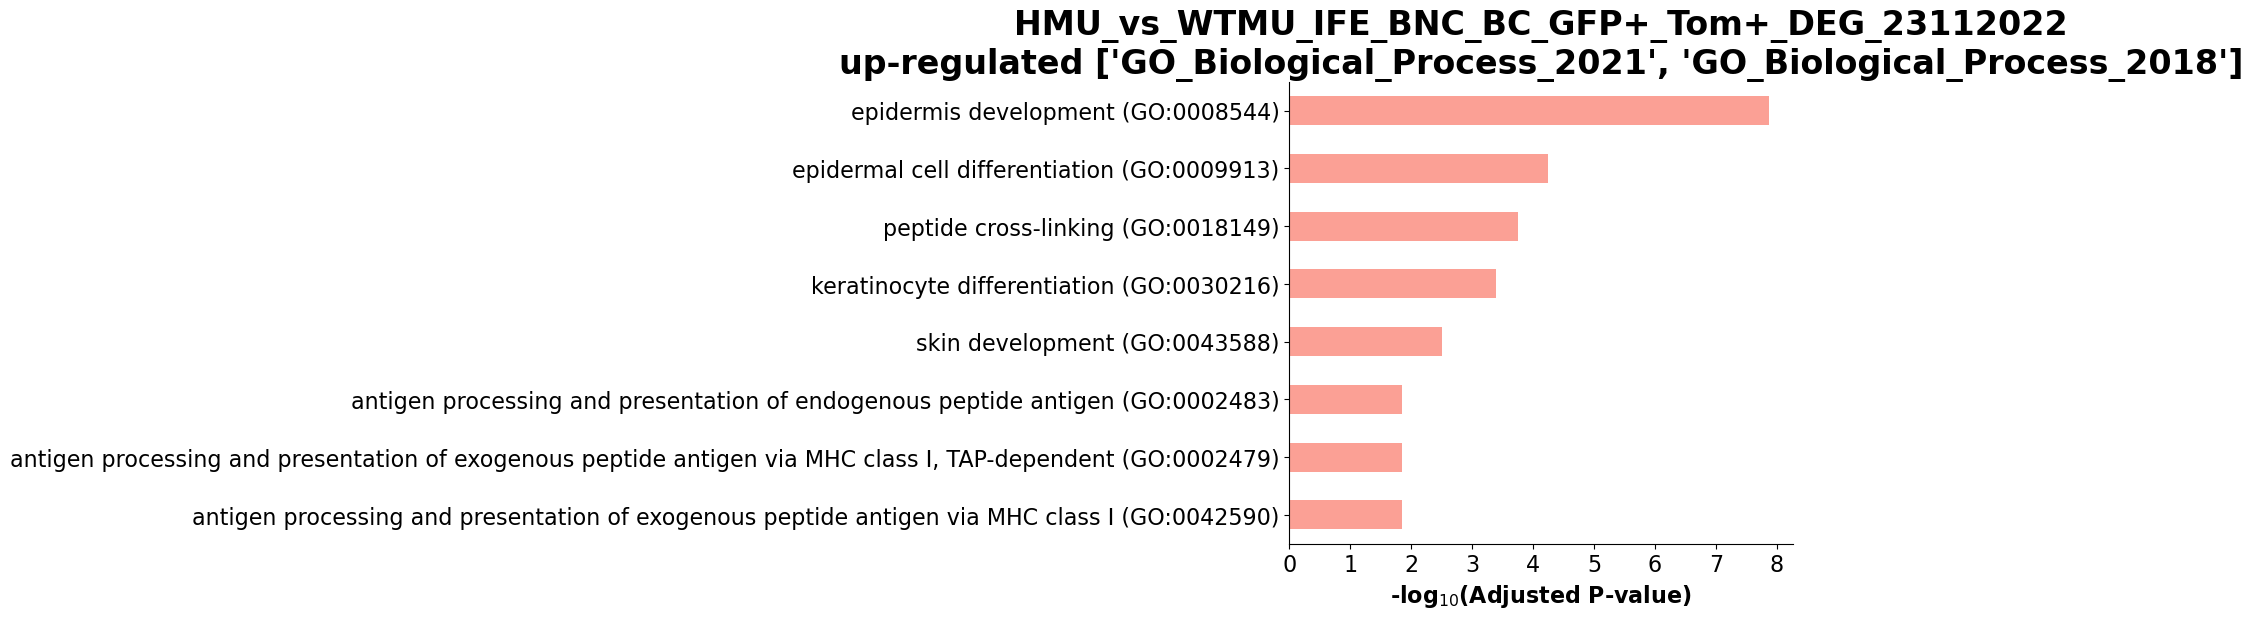

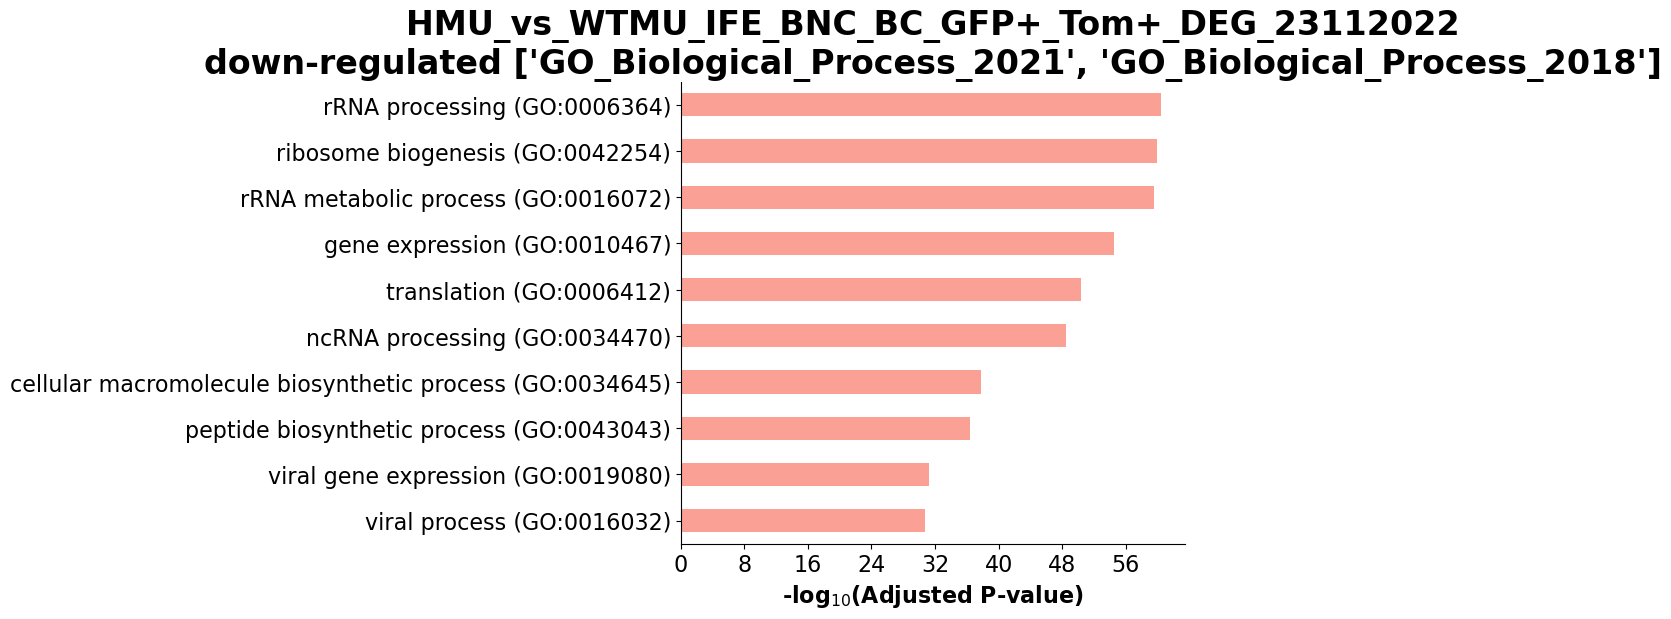

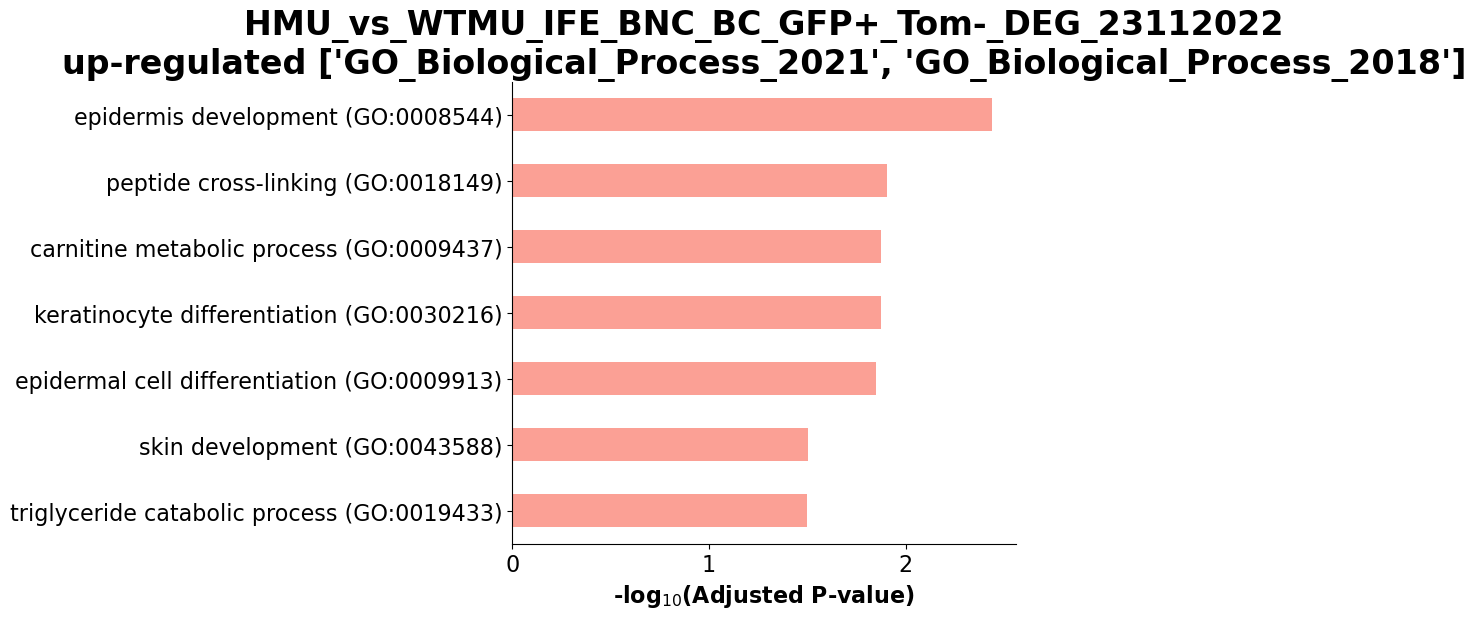

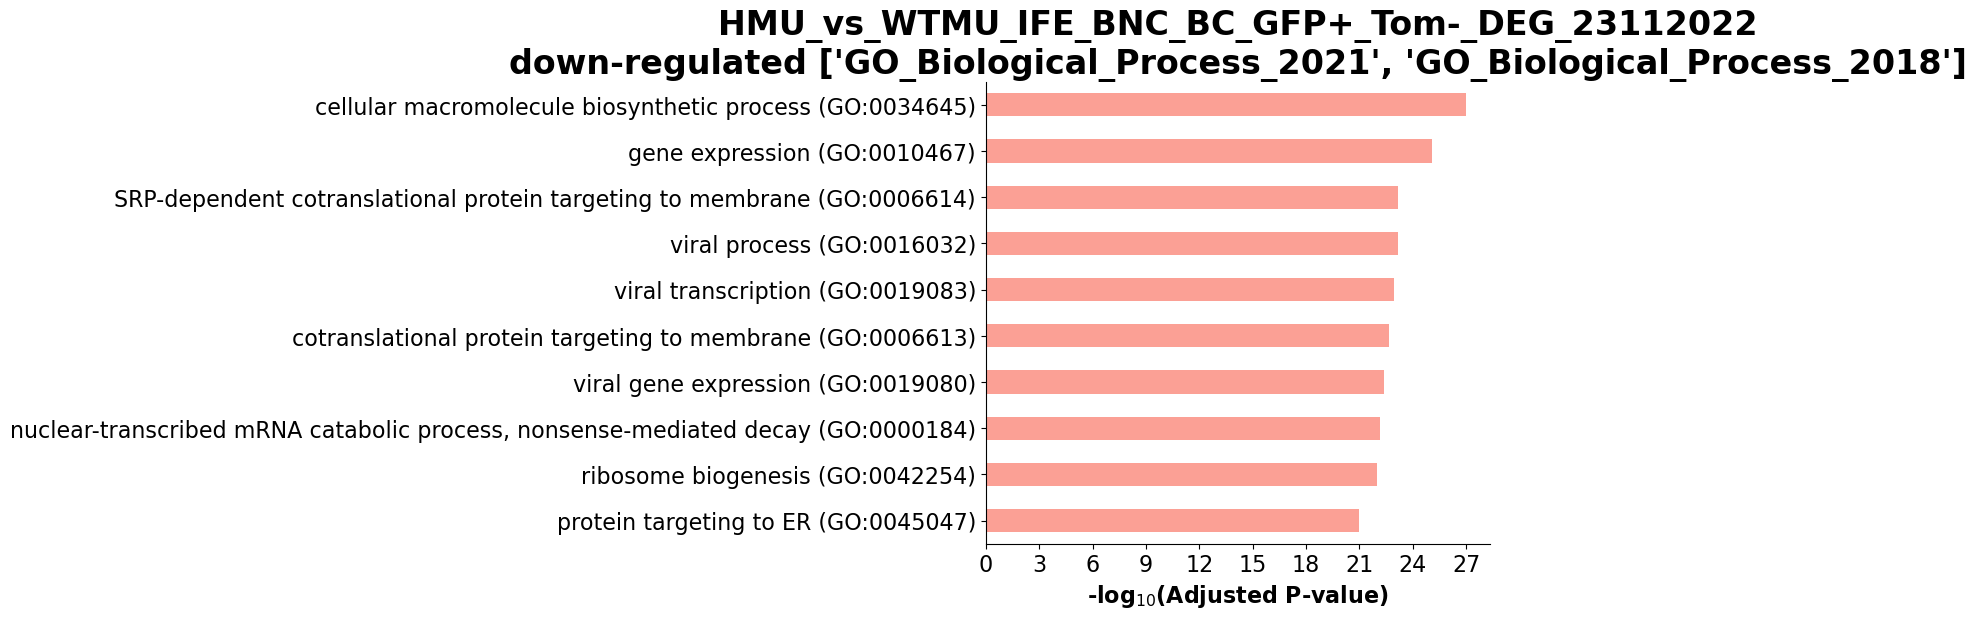

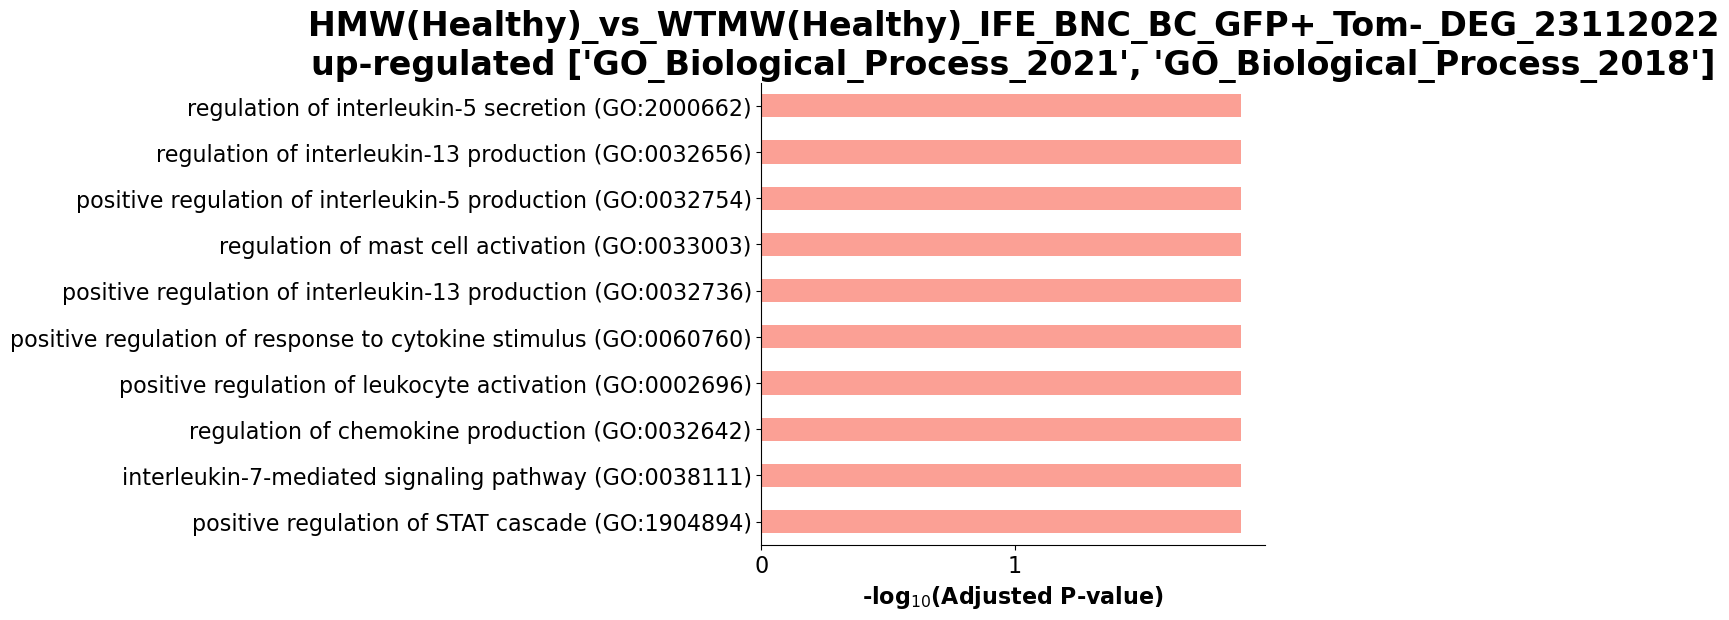

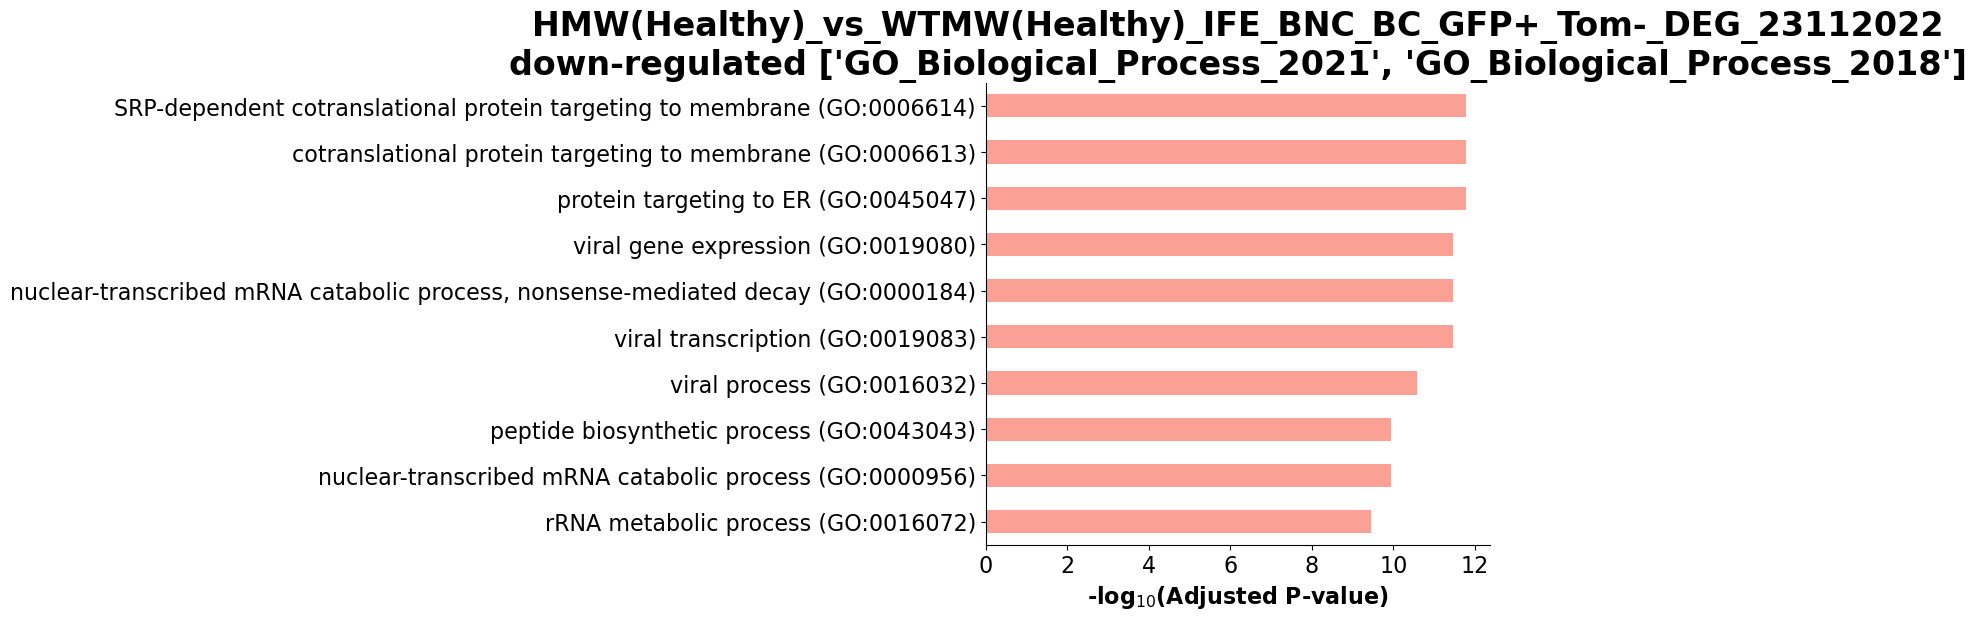

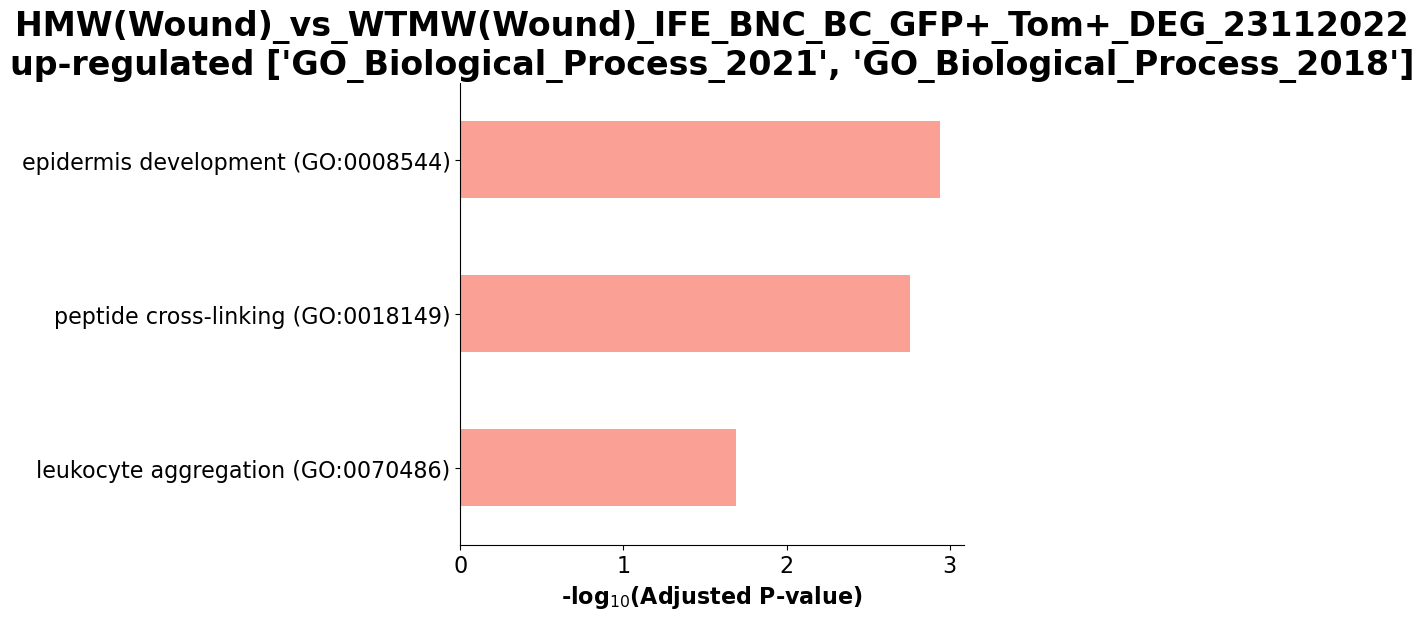

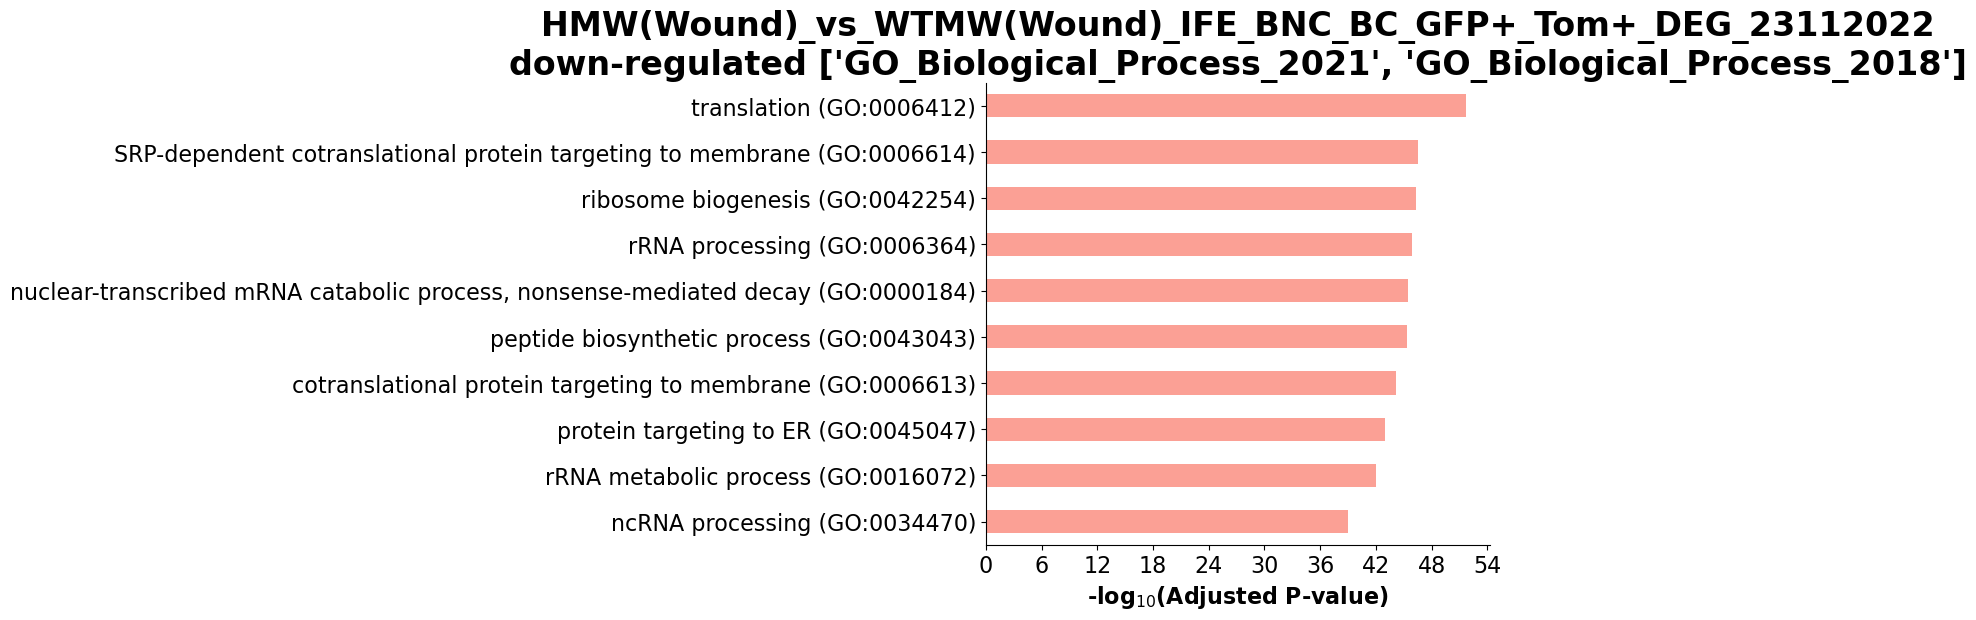

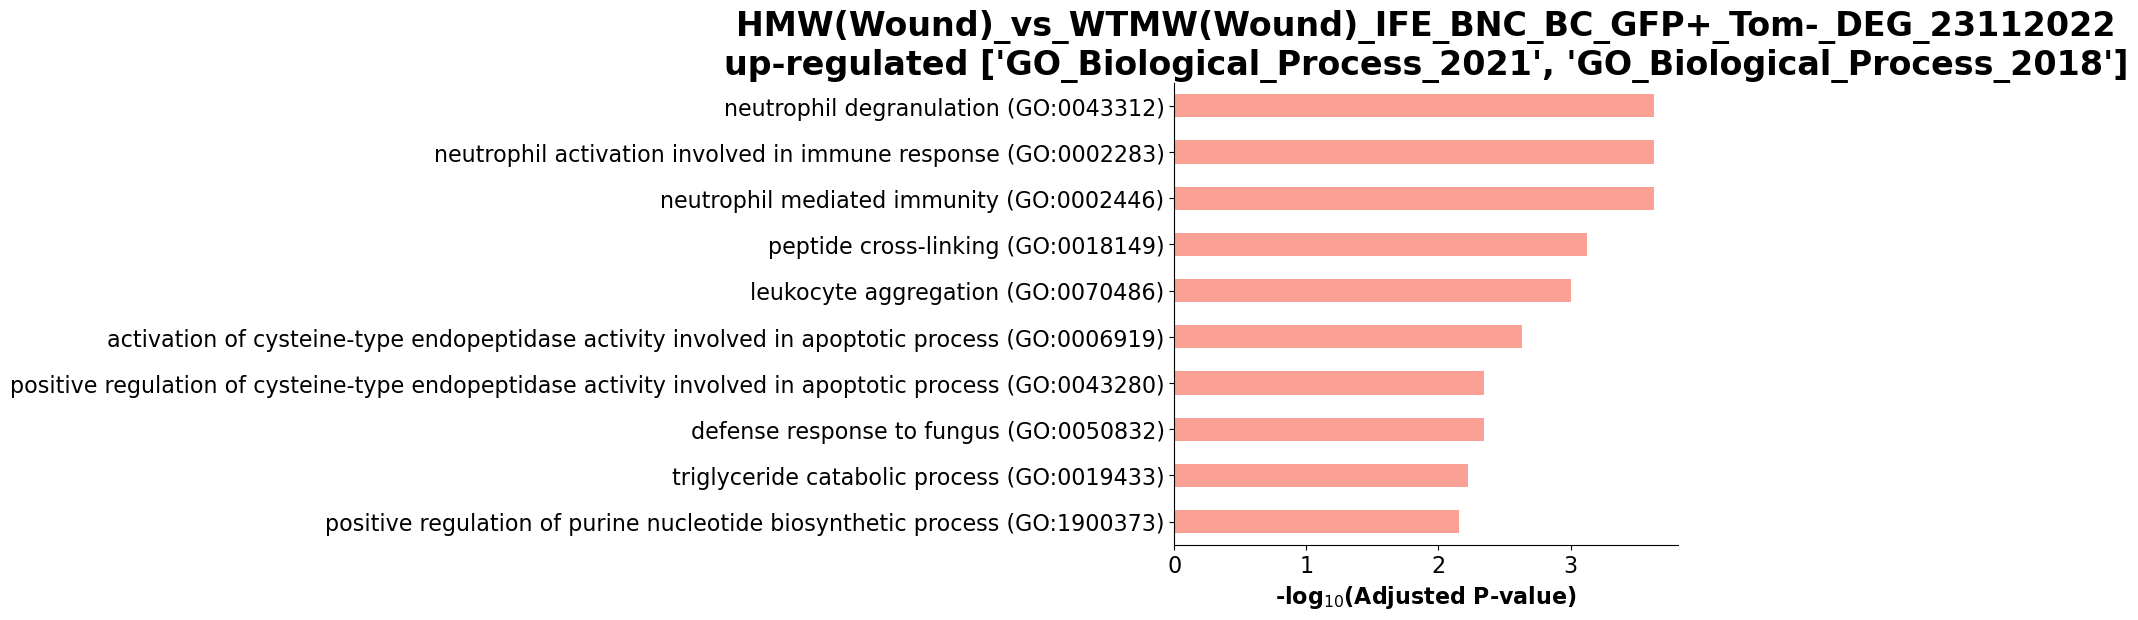

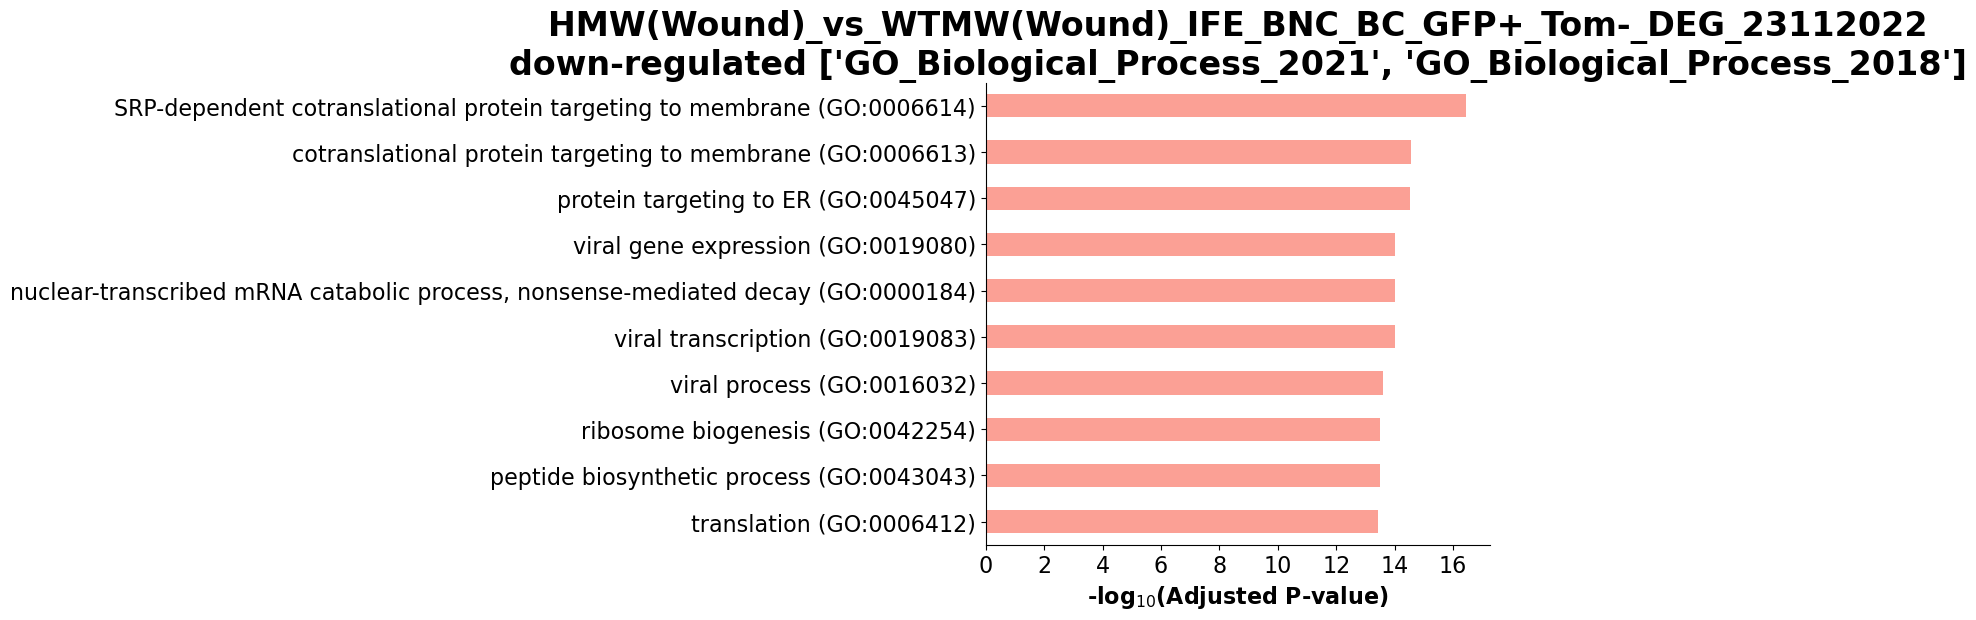

In [48]:
for file, gsea in res_dict.items():
    name = file.split('.')[0]
    for dge, gsea_res in gsea.items():
        res = gsea_res.results.to_csv(os.path.join(path, 'GO_Biological_Process', f'{name}_{dge}-regulated.csv'))
        gseapy.barplot(gsea_res.res2d, title=f'{name}\n{dge}-regulated {gene_sets}')

# Replot with lfc:0.5 cutoff

In [214]:
path = '/mnt/c/Users/User/Desktop/To Be Deleted/Delete me!/Sara_seq_raw_loom/GSEA_22112022'

date = 22112022
Tomato_class = 'Tom+'
GFP_class = 'GFP+'
commitment = ['Basal committed', 'Basal non-committed']
selection_title = f'{" + ".join(commitment) if type(commitment)==list else commitment}, {GFP_class}, {Tomato_class}'

datasets = ['HMW','WTMW']
wound = 'Wound'
deg_df = pd.read_csv(os.path.join(path, f'{datasets[0]}({wound})_vs_{datasets[1]}({wound})_IFE_BNC_BC_{GFP_class}_{Tomato_class}_DEG_{date}.csv'), index_col = 0)

In [215]:
deg_df

,names,scores,logfoldchanges,pvals,pvals_adj,pct_nz_group,-log10(pvals_adj),pct. HMW,pct. WTMWW,Samples,Expr. samples HMW,Expr. samples WTMWW,DEG lfc:0.5,DEG lfc:1
0,Rpl21,38.918274,0.545120,0.000000e+00,0.000000e+00,0.998254,300.000000,99.825404,99.889094,All samples,3,3,DEG,Non-DEG
1,S100a8,18.574844,1.280476,5.135434e-77,1.294065e-73,0.824094,72.888044,82.409428,61.035120,All samples,3,3,DEG,DEG
2,S100a9,17.485996,1.170838,1.831828e-68,3.692781e-65,0.856831,64.432646,85.683108,65.101664,All samples,3,3,DEG,DEG
3,Krt10,17.425188,1.272902,5.313270e-68,9.737292e-65,0.805762,64.011562,80.576168,46.691312,All samples,3,3,DEG,DEG
4,Cst6,17.058443,1.127934,3.025069e-65,4.690952e-62,0.563946,61.328739,56.394588,27.134935,All samples,3,3,DEG,DEG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20154,Tmem14c,-20.384720,-0.665630,2.285180e-92,7.677823e-89,0.838062,88.114762,83.806198,92.975970,All samples,3,3,DEG,Non-DEG
20155,Sec61b,-21.811464,-0.811455,1.806030e-105,7.281553e-102,0.756438,101.137776,75.643824,90.905730,All samples,3,3,DEG,Non-DEG
20156,tdTomato,-26.170475,-0.463733,5.763681e-151,2.904751e-147,1.000000,146.536891,100.000000,100.000000,All samples,3,3,Non-DEG,Non-DEG
20157,Ubb,-29.057802,-0.619666,1.226371e-185,8.240806e-182,0.986032,181.084030,98.603230,99.741220,All samples,3,3,DEG,Non-DEG


8

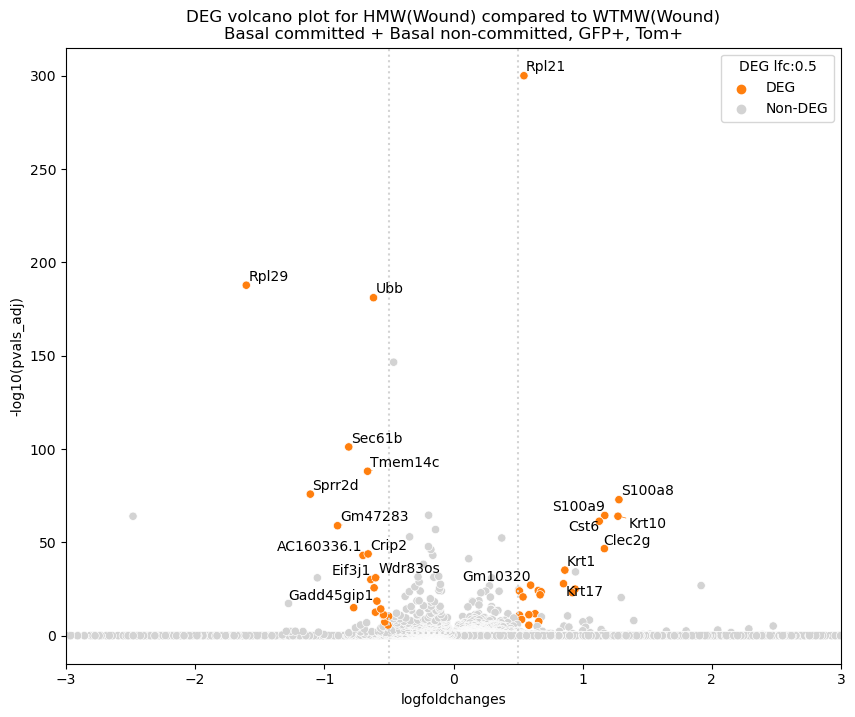

In [219]:
fig, ax = plt.subplots(figsize = (10, 8))
cmap = {'Non-DEG': 'lightgray', 'DEG':sbn.color_palette(n_colors = 2, palette = 'tab10')[1]}
sbn.scatterplot(data = deg_df, x = 'logfoldchanges', y = '-log10(pvals_adj)', hue = 'DEG lfc:0.5', ax = ax, palette = cmap)
ax.axhline(-np.log10(0.05), ls = ':', c = 'lightgrey')
[ax.axvline(y, ls = ':', c = 'lightgrey') for y in [-0.5, 0.5]]
ax.set_xlim([-3, 3])
ax.set_title(f'DEG volcano plot for {datasets[0]}({wound}) compared to {datasets[1]}({wound})\n{selection_title}')
if deg_df['DEG lfc:0.5'].value_counts()['DEG'] < 20:
    texts = [ax.text(x+0.01, y+0.01, s) for x, y, s in deg_df[deg_df['DEG lfc:0.5']=='DEG'][['logfoldchanges', '-log10(pvals_adj)', 'names']].values]
else:
    idxs = abs(deg_df[deg_df['DEG lfc:0.5']=='DEG']['scores']).sort_values(ascending = False).index[:20]
    texts = [ax.text(x+0.01, y+0.01, s) for x, y, s in deg_df[deg_df['DEG lfc:0.5']=='DEG'].loc[idxs][['logfoldchanges', '-log10(pvals_adj)', 'names']].values]
adjust_text(texts, arrowprops=dict(arrowstyle="-", color=cmap['DEG'], lw=0.5))

In [230]:
path = '/mnt/c/Users/User/Desktop/To Be Deleted/Delete me!/Sara_seq_raw_loom/GSEA_22112022'

date = 22112022
Tomato_class = 'Tom+'
GFP_class = 'GFP+'
commitment = ['Basal committed', 'Basal non-committed']
selection_title = f'{" + ".join(commitment) if type(commitment)==list else commitment}, {GFP_class}, {Tomato_class}'

datasets = ['HMU','WTMU']
wound = 'Healthy'
deg_df = pd.read_csv(os.path.join(path, f'{datasets[0]}_vs_{datasets[1]}_IFE_BNC_BC_{GFP_class}_{Tomato_class}_DEG_{date}.csv'), index_col = 0)

17

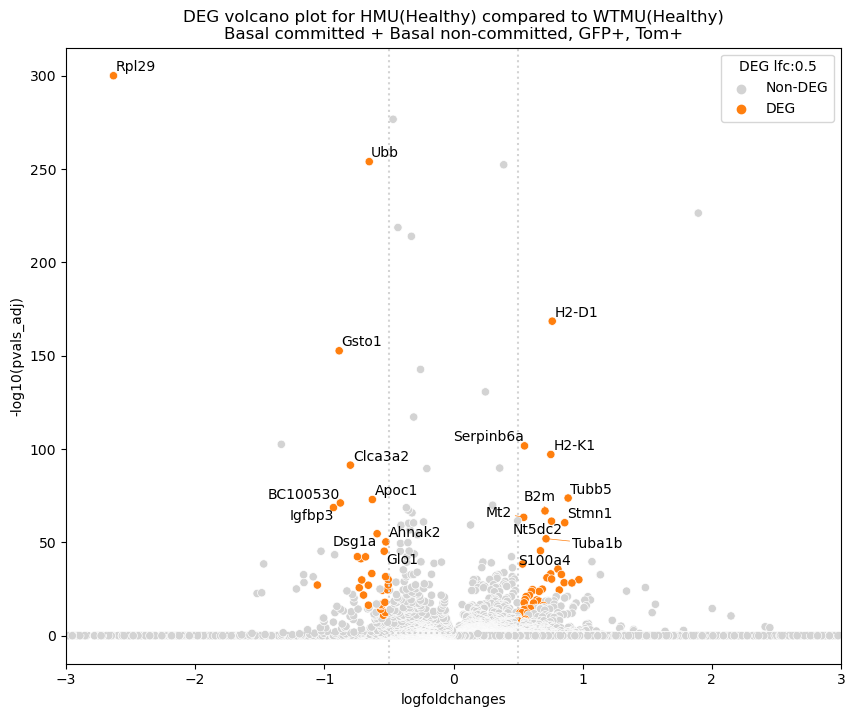

In [231]:
fig, ax = plt.subplots(figsize = (10, 8))
cmap = {'Non-DEG': 'lightgray', 'DEG':sbn.color_palette(n_colors = 2, palette = 'tab10')[1]}
sbn.scatterplot(data = deg_df, x = 'logfoldchanges', y = '-log10(pvals_adj)', hue = 'DEG lfc:0.5', ax = ax, palette = cmap)
ax.axhline(-np.log10(0.05), ls = ':', c = 'lightgrey')
[ax.axvline(y, ls = ':', c = 'lightgrey') for y in [-0.5, 0.5]]
ax.set_xlim([-3, 3])
ax.set_title(f'DEG volcano plot for {datasets[0]}({wound}) compared to {datasets[1]}({wound})\n{selection_title}')
if deg_df['DEG lfc:0.5'].value_counts()['DEG'] < 20:
    texts = [ax.text(x+0.01, y+0.01, s) for x, y, s in deg_df[deg_df['DEG lfc:0.5']=='DEG'][['logfoldchanges', '-log10(pvals_adj)', 'names']].values]
else:
    idxs = abs(deg_df[deg_df['DEG lfc:0.5']=='DEG']['scores']).sort_values(ascending = False).index[:20]
    texts = [ax.text(x+0.01, y+0.01, s) for x, y, s in deg_df[deg_df['DEG lfc:0.5']=='DEG'].loc[idxs][['logfoldchanges', '-log10(pvals_adj)', 'names']].values]
adjust_text(texts, arrowprops=dict(arrowstyle="-", color=cmap['DEG'], lw=0.5))

In [233]:
path = '/mnt/c/Users/User/Desktop/To Be Deleted/Delete me!/Sara_seq_raw_loom'
raw_data.write_loom(os.path.join(path, 'IFE_combined_RAW.loom'))

The loom file will lack these fields:
{'X_umap', 'X_pca'}
Use write_obsm_varm=True to export multi-dimensional annotations
